# GerryDB training (April 27, 2023)

## One-time setup
Enable the two cells below to install and configure GerryDB. Make sure to substitute your own API key.

## Key concepts
* A **view** is essentially a DataFrame and a graph rolled into one, plus some metadata.
* Views are dynamically composed from...
    * **Localities**: abstract definitions of places (e.g. Massachusetts or Atlanta); the precise boundaries of a locality may shift over time due to (de)annexation and the like.
    * **Geographic layers**: units that tile localities (e.g. Census blocks, state precincts).
    * **View templates**: a reusable grouping of data columns (e.g. population statistics, election results).
    * **Adjacency graphs**.


## Loading a view

In [1]:
from gerrydb import GerryDB
import matplotlib.pyplot as plt

In [2]:
db = GerryDB(namespace="census.2020", profile="gcp")

In [3]:
bg_view = db.views['ma_bg_demo']

In [4]:
bg_view.template

ViewTemplate(path='basic_pops', description='Total population and VAP.', namespace='census.2020', members=[Column(canonical_path='total_pop', namespace='census.2020', description='2020 U.S. Census population by race: Total', source_url=AnyUrl('https://api.census.gov/data/2020/dec/pl/groups/P1/', scheme='https', host='api.census.gov', tld='gov', host_type='domain', path='/data/2020/dec/pl/groups/P1/'), kind=<ColumnKind.COUNT: 'count'>, type=<ColumnType.INT: 'int'>, aliases=['p1_001n', 'p001001', 'p0010001', 'p2_001n', 'p002001', 'p0020001'], meta=ObjectMeta(notes='ETL script /home/pjrule/cherrydb/cherrydb-etl/cherrydb_etl/bootstrap/pl_pop_table_columns.py: creating columns for 2020 U.S. Census P.L. 94-171 Table P1 (Race)', uuid='801e29c4-d66b-4fd4-9d7e-d8db5d72b1fb', created_at=datetime.datetime(2023, 3, 15, 20, 37, 41, 809141, tzinfo=datetime.timezone.utc), created_by='parker@mggg.org')), Column(canonical_path='total_vap', namespace='census.2020', description='2020 U.S. Census voting-a

In [5]:
for member in bg_view.template.members:
    print(member.canonical_path, "-", member.description, f"({member.kind}, {member.type})")

total_pop - 2020 U.S. Census population by race: Total (count, int)
total_vap - 2020 U.S. Census voting-age population by race: Total (count, int)


In [6]:
bg_view.layer

GeoLayer(path='bg', description='2020 U.S. Census block groups', source_url=None, meta=ObjectMeta(notes='Creating geographic layer "bg" from CLI', uuid='86d9225d-c499-4994-9d6f-744f91f1f6df', created_at=datetime.datetime(2023, 3, 15, 20, 36, 35, 967021, tzinfo=datetime.timezone.utc), created_by='parker@mggg.org'), namespace='census.2020')

In [7]:
bg_view.locality

Locality: Massachusetts (massachusetts → us)

In [8]:
bg_view.meta

ObjectMeta(notes='MA view (with graph and plan) for performance testing', uuid='e9a25649-b7ab-4814-9e21-12cae131baf4', created_at=datetime.datetime(2023, 4, 27, 17, 1, 12, 38073, tzinfo=datetime.timezone.utc), created_by='parker@mggg.org')

In [9]:
bg_df = bg_view.to_df()
bg_df

,total_pop,total_vap,geometry
path,,,
250010121011,1624,1294,"POLYGON ((395325.231 4615582.422, 395336.904 4..."
250010121015,1078,903,"POLYGON ((396355.733 4613262.077, 396390.512 4..."
250010121013,970,805,"POLYGON ((397814.689 4613365.189, 397829.092 4..."
250010121014,820,656,"POLYGON ((397314.295 4611931.596, 397317.117 4..."
250277552022,1029,814,"POLYGON ((254413.475 4661379.791, 254415.258 4..."
...,...,...,...
250251601032,1081,769,"POLYGON ((332535.509 4694762.121, 332543.224 4..."
250251601024,548,380,"POLYGON ((332984.398 4695210.255, 332990.613 4..."
250250711013,996,940,"POLYGON ((329122.107 4689435.581, 329164.296 4..."


In [10]:
bg_df.crs

<Derived Projected CRS: EPSG:26919>
Name: NAD83 / UTM zone 19N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 72°W and 66°W - onshore and offshore. Canada - Labrador; New Brunswick; Nova Scotia; Nunavut; Quebec. Puerto Rico. United States (USA) - Connecticut; Maine; Massachusetts; New Hampshire; New York (Long Island); Rhode Island; Vermont.
- bounds: (-72.0, 14.92, -66.0, 84.0)
Coordinate Operation:
- name: UTM zone 19N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

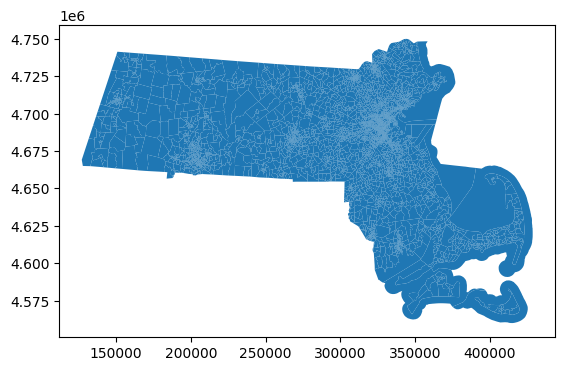

In [11]:
bg_df.plot()
plt.show()

In [12]:
graph = bg_view.to_graph()

In [13]:
graph.nodes['250173731001']

{'total_pop': 839, 'total_vap': 687, 'ma_bg_one': '1'}

In [14]:
partitions = bg_view.to_chain()
partitions

{'ma_bg_one': <Partition [1 part]>}

In [15]:
partitions['ma_bg_one'].updaters

{'cut_edges': <function gerrychain.updaters.cut_edges.cut_edges(partition)>,
 'total_pop': <gerrychain.updaters.tally.Tally at 0x7fb45a12c4c0>,
 'total_vap': <gerrychain.updaters.tally.Tally at 0x7fb449c249c0>}

## Let's try blocks...

In [16]:
block_view = db.views['ma_block_geo']

In [17]:
block_df = block_view.to_df()
block_df

,total_pop,total_vap,geometry
path,,,
250039353003056,36,36,"POLYGON ((163350.053 4735588.121, 163367.330 4..."
250039201021019,82,77,"POLYGON ((152647.239 4732000.800, 152658.799 4..."
250039261001041,3,3,"POLYGON ((135409.991 4673704.365, 135425.320 4..."
250039311002021,13,13,"POLYGON ((165353.242 4736652.375, 165365.064 4..."
250039261001071,7,3,"POLYGON ((142208.311 4669814.520, 142223.651 4..."
...,...,...,...
250173839044009,25,22,"POLYGON ((298945.941 4689526.149, 298977.275 4..."
250173422021016,101,87,"POLYGON ((331594.921 4698444.152, 331597.876 4..."
250173336011038,0,0,"POLYGON ((323549.466 4708733.871, 323630.344 4..."


## How the sausage is made: creating a view

```python
with db.context(notes="MA view creation for demo") as ctx:
 view = ctx.views.create(
    path="ma_bg_demo",
    template="basic_pops",
    locality="massachusetts",
    layer="bg",
    graph="/census.2020/ma_bg_rook",
)
```